# 6 Linear Models and Regularization Methods
## 6.5.1 Subset Selection Methods

In [1]:
max_feature = 3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [2]:
# read the data and take a look at the data
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
print(list(Hitters)) # get the header of this data
print(Hitters.shape) # get the dimension of this 
Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# clean the data a bit to remove NAs
print(np.sum(pd.isnull(Hitters['Salary']))) # number of NAs in Salary column'
print(Hitters['Salary'].isnull().sum())

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
print(Hitters.shape)
print(Hitters['Salary'].isnull().sum())

59
59
(263, 20)
0


In [4]:
y = Hitters.Salary  

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print(dummies.head())
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [5]:
# best subset selection 
"""
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model

In [6]:
# execute the best model selection 
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models.loc[i] = bestModel(y, X, i)
    
print(models.loc[2, 'Model'].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                    5.80e-82
Time:                        16:29:24   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

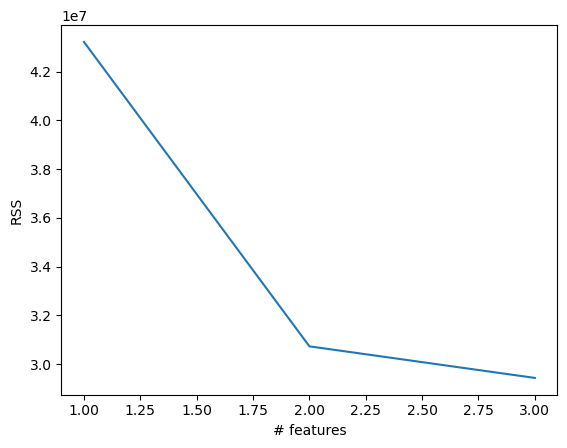

In [7]:
# this show an example to plot the RSS of best models with different number of parameters
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [8]:
# find the adjust R^2, use dir() to identify all available attributes
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) 

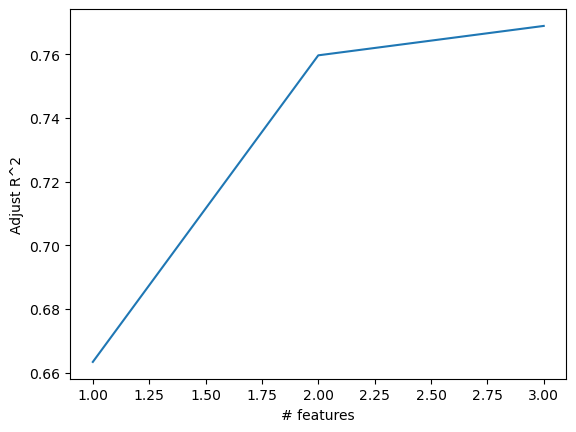

In [9]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection
### Forward Stepwise Selection

In [10]:
# we can use the previous user defined function 'def getRSS(y, X, feature_list)' 
# to add 1 feature at a time (start from 0 feature) for forward stepwise selection
# or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [11]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [12]:
# we can compare the results of best subset selection and the forward selection
print('Best max_feature variable from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64


### Backward Stepwise Selection

In [13]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [14]:
# the backward selection starts from all the variables of features
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print(models3.loc[max_feature, "Model"].params)

Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation


In [15]:
# randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set.
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [16]:
""" 
We can recyle the old functions. Modification is needed to compute the RSS for the testing data. 
So we need to add both train and test into the function input (Implemented)
-OR-: we can wrap the train and test split step into the function(Not Implemented)
"""
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [17]:
models_validation = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 
    
    
"""
change the function to  forward_select_validation (.) or backward_select_validation(.) 
for forward selection or backward selection
""" 
    
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models2_forward.loc[i]["Model"].model.exog_names    


In [18]:
print('Best max_feature variable from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from backward selection on tranining')
print(models3.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from best subset selection on traning and validation split')
print(models_validation.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best max_feature variable from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64


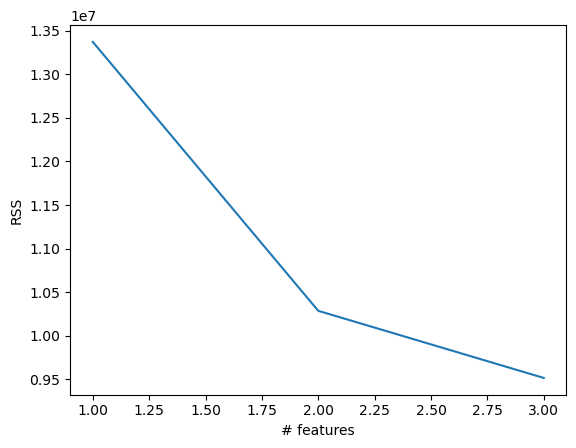

In [19]:
# this show an example to plot the RSS of best models with different number of parameters for best subset with validation
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

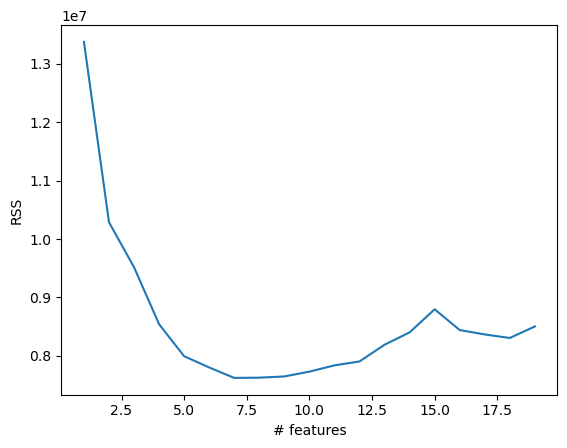

'\nNote:from above graph, that 6 variables model gives us the best RSS under forward selection. \nTo learn the final model, it is also recommendated to re-train the model on entire data (train + validation). \n'

In [20]:
# this show an example to plot the RSS of best models with different number of parameters for forward selection with validation
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
"""
Note:from above graph, that 6 variables model gives us the best RSS under forward selection. 
To learn the final model, it is also recommendated to re-train the model on entire data (train + validation). 
"""

### Cross-Validation

In [21]:
"""
This approach is similar to the previous validation idea. 
The difference is that we break the entire dataset into K different folds. 
Each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold.
Advantages: 
1. There will be multiple metrics out of testing results => distribution of testing RSS, etc
2. The size of traning dataset is much closer to the size of original dateset. This will remove some biases caused by
the size difference.
"""

k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [22]:
# train and test on each fold
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

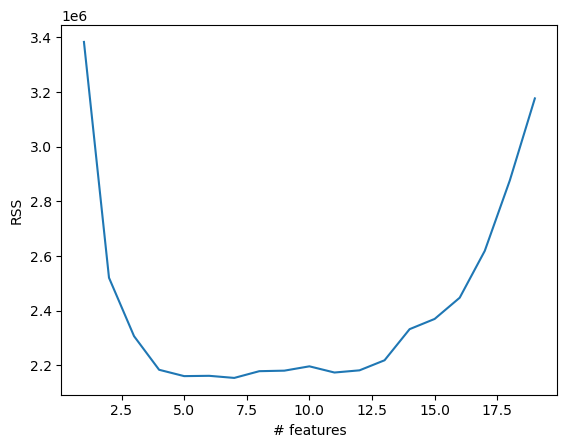

In [23]:
# similar to above, let us plot the performance of each model 
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [24]:
"""
From the above plot, we can see that the model with 5 variables yielded the smallest RSS.
We can take a closer look at that model summary. 
We can also see that the model performance for variables 4 - 12 are similar.
"""
print(models_cv.loc[5, "Model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.771
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              155.0
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                    1.40e-71
Time:                        16:35:18   Log-Likelihood:                         -1704.1
No. Observations:                 235   AIC:                                      3418.
Df Residuals:                     230   BIC:                                      3435.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 6.5.2 Ridge Regression and the Lasso

In [26]:
"""
Ridge and Lasso are the two regularization methods to deal with overfitting. 
We do not to run multiple backward/forward selection. 
In Ridge and Lasso , we would need to run the regularization strength.
"""

# similar to before, we need to prepare the features(indepedent) variables and response(depedent) varisble.
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

### Ridge Regression

In [28]:
# next, we will generate a few canadidates regularization strength(in sklearn, the keyword is alphas) 
# for our Ridge regression. In R, alpha is a switch for Ridge and Lasso methods.
alphas = 10**np.linspace(10,-2,100)
print(alphas)

[1.00000000e+10 7.56463328e+09 5.72236766e+09 4.32876128e+09
 3.27454916e+09 2.47707636e+09 1.87381742e+09 1.41747416e+09
 1.07226722e+09 8.11130831e+08 6.13590727e+08 4.64158883e+08
 3.51119173e+08 2.65608778e+08 2.00923300e+08 1.51991108e+08
 1.14975700e+08 8.69749003e+07 6.57933225e+07 4.97702356e+07
 3.76493581e+07 2.84803587e+07 2.15443469e+07 1.62975083e+07
 1.23284674e+07 9.32603347e+06 7.05480231e+06 5.33669923e+06
 4.03701726e+06 3.05385551e+06 2.31012970e+06 1.74752840e+06
 1.32194115e+06 1.00000000e+06 7.56463328e+05 5.72236766e+05
 4.32876128e+05 3.27454916e+05 2.47707636e+05 1.87381742e+05
 1.41747416e+05 1.07226722e+05 8.11130831e+04 6.13590727e+04
 4.64158883e+04 3.51119173e+04 2.65608778e+04 2.00923300e+04
 1.51991108e+04 1.14975700e+04 8.69749003e+03 6.57933225e+03
 4.97702356e+03 3.76493581e+03 2.84803587e+03 2.15443469e+03
 1.62975083e+03 1.23284674e+03 9.32603347e+02 7.05480231e+02
 5.33669923e+02 4.03701726e+02 3.05385551e+02 2.31012970e+02
 1.74752840e+02 1.321941

In [ ]:
ridge = Ridge(fit_intercept=True, normalize=True)
coeffs = []
intercepts = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

In [30]:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0])

100
19
100
535.9258816915063


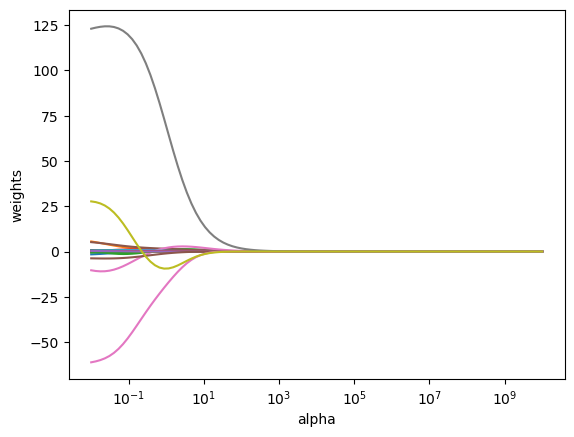

In [31]:
# as design, as alphas get bigger, magnitude of coefficients turn to be closer to zero. 
# one thing to remember is that the decay is quite smooth
ax = plt.gca()
ax.plot(alphas, coeffs)
"""
Typically, we scale the alpha in log scale.
Try to plot it without. 
"""
ax.set_xscale('log') 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [32]:
# let us take one example
"""
We may notice the coefficients l2 norm is different from R output 
I tried a few different normalization methods but still did not get the exact same output 
"""
sample = 49
print(alphas[sample])
print(math.sqrt(sum(map(lambda x:x*x, coeffs[sample]))))
print(coeffs[sample])


11497.569953977356
0.015604015364701402
[ 1.05084190e-04  3.81213219e-04  1.53587268e-03  6.44641457e-04
  6.80918080e-04  8.01446032e-04  3.27704404e-03  9.02214059e-06
  3.32048758e-05  2.50408429e-04  6.66164023e-05  6.87496444e-05
  7.27332307e-05  4.21005722e-05  6.87621309e-06 -3.21056660e-05
  1.11649125e-03  1.50775795e-02  2.19838773e-04]


In [33]:
# we now split the samples into a training set and a test set in order to estimate 
# the test error of ridge regression and the lasso. 
# Python provides a built-in function to produce training and test data set.
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

In [35]:
# train the model and do prediction on test dataset
ridge = Ridge(fit_intercept=True,  alpha=4)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat           -1.608293
Hits             6.211977
HmRun            7.948951
Runs            -7.379364
RBI             -1.117944
Walks            9.002566
Years            2.056480
CAtBat           0.386704
CHits           -2.605736
CHmRun          -1.300568
CRuns            2.896104
CRBI             1.829480
CWalks          -1.477121
PutOuts          0.447622
Assists          0.392928
Errors           0.368711
League_A         4.172516
Division_E     118.476804
NewLeague_A    -27.630930
dtype: float64
170639.33819448636


In [37]:
# to select best alpha, we will use cross validation. 
# as standard, we will report test set performance as the final performance metric
ridgecv =  RidgeCV(alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

572236.765935022

In [38]:
# produce the mean squred error of the selected alpha on test dataset
ridge_best = Ridge(alpha=ridgecv.alpha_)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

144732.27236051077

In [39]:
# we can exame the values of the coefficients 
"""
If we exam the values of the coefficients, most of them are tiny, but none of them is zero.
This is a diff between ridge and lasso. Ridge shrinks the coefficients proportionally.
"""
pd.Series(ridge_best.coef_, index=X.columns)

AtBat          0.181014
Hits           0.139367
HmRun          0.043630
Runs           0.093814
RBI            0.130076
Walks          0.191343
Years          0.000794
CAtBat         0.018760
CHits         -0.191924
CHmRun         0.404774
CRuns          0.234803
CRBI           0.825852
CWalks         0.032785
PutOuts        0.397671
Assists        0.224188
Errors        -0.002481
League_A      -0.000554
Division_E     0.006136
NewLeague_A   -0.000518
dtype: float64

###  The Lasso
#### We saw that ridge regression with a wise choice of λ can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression.

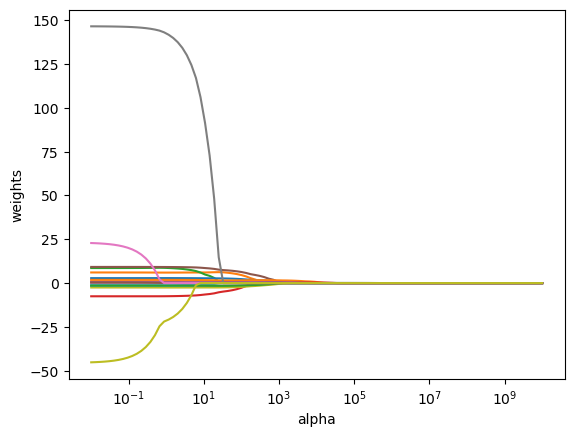

150445.9826433616

In [44]:
# same precedure as before, we will use cross validation to select the best alpha
lasso= Lasso(max_iter=100000) 
coeffs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

In [45]:
# some of the coefficients should reduce to exact zero
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.165941
Hits           0.000000
HmRun          0.000000
Runs           0.000000
RBI            0.000000
Walks          0.000000
Years         -0.000000
CAtBat        -0.037354
CHits         -0.000000
CHmRun         0.000000
CRuns          0.000000
CRBI           1.233150
CWalks        -0.000000
PutOuts        0.383567
Assists        0.180175
Errors         0.000000
League_A      -0.000000
Division_E     0.000000
NewLeague_A   -0.000000
dtype: float64

## 6.5.3 PCR and PLS Regression
### Principal Components Regression

In [50]:
"""
Here comes a problem, how to choose the number of PCs. We still use cross-validation. 
We compute MSE for validation set at different number of PCs, 
and choose the one with lowest validation MSE as the optimal number for PCA dimension reduction. 

[NOT fully covered here, covered in Chapter 12] We may decide on the number of PCS by the explained variance ratio.
"""

def pcr(X,y,pc):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    # Define the PCA object
    pca = PCA()

    # Preprocessing (1): first derivative
    X_pca = pca.fit_transform(scale(X))[:,:pc]

    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Fit
    regr.fit(X_pca, y)

    # Calibration
    y_train = regr.predict(X_pca)

    # Cross-validation
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    # Calculate scores for training and cross-validation
    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for training and cross validation
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)


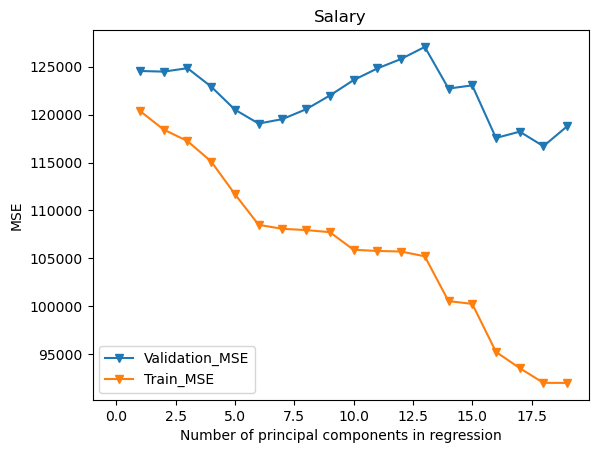

'\nFrom the above picture, we can observe three things \n1)PC = 6, 16, 17, 18, 19 give us the small validation MSE; \n2) for all the PC dimensions,  validation MSE is higher than training MSE, is this normal? \n3) the training MSE keeps decreasing as PC number goes up, is this as expected?\n\n\nFrom the plot we also see that the cross-validation error is roughly the same when \nonly one component is included in the model. \nThis suggests that a model that uses just a small number of components might suffice. \nIn the book, the authors used train/test to select the best dimension. \nI will skip that part since most of those were already covered in the previous sections.\n'

In [47]:
mse_train = []
mse_cv = []

# calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    results =  pcr(X,y,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# plot results    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(left=-1)
plt.legend()
plt.show()

"""
From the above picture, we can observe three things 
1)PC = 6, 16, 17, 18, 19 give us the small validation MSE; 
2) for all the PC dimensions,  validation MSE is higher than training MSE, is this normal? 
3) the training MSE keeps decreasing as PC number goes up, is this as expected?


From the plot we also see that the cross-validation error is roughly the same when 
only one component is included in the model. 
This suggests that a model that uses just a small number of components might suffice. 
In the book, the authors used train/test to select the best dimension. 
I will skip that part since most of those were already covered in the previous sections.
"""

In [48]:
# let us move forwward with 6 PCs
pcs = 6
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

pca2 = PCA()
# scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
X_reduced_test = pca2.transform(scale(X_test))[:,:pcs]
# train regression model on training data 
regr = linear_model.LinearRegression()
regr.fit(X_reduced_train[:,:6], y_train)
# prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

132732.59028866832

In [53]:
"""
We'll do a little math to get the amount of variance explained by adding each consecutive principal component. 
We can think of this as the amount of information(variance) about the data(X) or the response that is 
captured using $M$ principal components. 
For example, setting $M = 1$ only captures 38.31% of all the variance, or information, in the data.
"""
np.cumsum(pca2.explained_variance_ratio_) * 100

array([ 39.88573525,  59.44996346,  70.77159326,  80.31463005,
        85.51723177,  89.58899092,  92.45181624,  95.20878639,
        96.36412991,  97.31080921,  98.16677746,  98.74587983,
        99.2580129 ,  99.57918942,  99.79361237,  99.91662601,
        99.97948194,  99.99644996, 100.        ])

### Partial Least Squares

In [54]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

132658.32661093544